In [0]:
import numpy

import theano
import theano.tensor as T


class LogisticRegression(object):
    """Multi-class Logistic Regression Class

    The logistic regression is fully described by a weight matrix :math:`W`
    and bias vector :math:`b`. Classification is done by projecting data
    points onto a set of hyperplanes, the distance to which is used to
    determine a class membership probability.
    """

    def __init__(self, input, n_in, n_out):
        """ Initialize the parameters of the logistic regression

        :type input: theano.tensor.TensorType
        :param input: symbolic variable that describes the input of the
                      architecture (one minibatch)

        :type n_in: int
        :param n_in: number of input units, the dimension of the space in
                     which the datapoints lie

        :type n_out: int
        :param n_out: number of output units, the dimension of the space in
                      which the labels lie

        """
        # start-snippet-1
        # initialize with 0 the weights W as a matrix of shape (n_in, n_out)
        self.W = theano.shared(
            value=numpy.zeros(
                (n_in, n_out),
                dtype=theano.config.floatX
            ),
            name='W',
            borrow=True
        )
        # initialize the biases b as a vector of n_out 0s
        self.b = theano.shared(
            value=numpy.zeros(
                (n_out,),
                dtype=theano.config.floatX
            ),
            name='b',
            borrow=True
        )

        # symbolic expression for computing the matrix of class-membership
        # probabilities
        # Where:
        # W is a matrix where column-k represent the separation hyperplane for
        # class-k
        # x is a matrix where row-j  represents input training sample-j
        # b is a vector where element-k represent the free parameter of
        # hyperplane-k
        self.p_y_given_x = T.nnet.softmax(T.dot(input, self.W) + self.b)

        # symbolic description of how to compute prediction as class whose
        # probability is maximal
        self.y_pred = T.argmax(self.p_y_given_x, axis=1)
        # end-snippet-1

        # parameters of the model
        self.params = [self.W, self.b]

        # keep track of model input
        self.input = input

    def negative_log_likelihood(self, y):
        """Return the mean of the negative log-likelihood of the prediction
        of this model under a given target distribution.

        .. math::

            \frac{1}{|\mathcal{D}|} \mathcal{L} (\theta=\{W,b\}, \mathcal{D}) =
            \frac{1}{|\mathcal{D}|} \sum_{i=0}^{|\mathcal{D}|}
                \log(P(Y=y^{(i)}|x^{(i)}, W,b)) \\
            \ell (\theta=\{W,b\}, \mathcal{D})

        :type y: theano.tensor.TensorType
        :param y: corresponds to a vector that gives for each example the
                  correct label

        Note: we use the mean instead of the sum so that
              the learning rate is less dependent on the batch size
        """
        # start-snippet-2
        # y.shape[0] is (symbolically) the number of rows in y, i.e.,
        # number of examples (call it n) in the minibatch
        # T.arange(y.shape[0]) is a symbolic vector which will contain
        # [0,1,2,... n-1] T.log(self.p_y_given_x) is a matrix of
        # Log-Probabilities (call it LP) with one row per example and
        # one column per class LP[T.arange(y.shape[0]),y] is a vector
        # v containing [LP[0,y[0]], LP[1,y[1]], LP[2,y[2]], ...,
        # LP[n-1,y[n-1]]] and T.mean(LP[T.arange(y.shape[0]),y]) is
        # the mean (across minibatch examples) of the elements in v,
        # i.e., the mean log-likelihood across the minibatch.
        return -T.mean(T.log(self.p_y_given_x)[T.arange(y.shape[0]), y])
        # end-snippet-2

    def errors(self, y):
        """Return a float representing the number of errors in the minibatch
        over the total number of examples of the minibatch ; zero one
        loss over the size of the minibatch

        :type y: theano.tensor.TensorType
        :param y: corresponds to a vector that gives for each example the
                  correct label
        """

        # check if y has same dimension of y_pred
        if y.ndim != self.y_pred.ndim:
            raise TypeError(
                'y should have the same shape as self.y_pred',
                ('y', y.type, 'y_pred', self.y_pred.type)
            )
        # check if y is of the correct datatype
        if y.dtype.startswith('int'):
            # the T.neq operator returns a vector of 0s and 1s, where 1
            # represents a mistake in prediction
            return T.mean(T.neq(self.y_pred, y))
        else:
            raise NotImplementedError()

In [0]:
import os
import sys
import timeit
import numpy
import theano
import theano.tensor as T
# from logisticstudent import LogisticRegression


class HiddenLayer(object):
    def __init__(self, rng, input, n_in, n_out, W=None, b=None,
                 activation=T.tanh):
        """
        Typical hidden layer of a MLP: units are fully-connected and have
        sigmoidal activation function. Weight matrix W is of shape (n_in,n_out)
        and the bias vector b is of shape (n_out,).

        NOTE : The nonlinearity used here is tanh

        Hidden unit activation is given by: tanh(dot(input,W) + b)

        :type rng: numpy.random.RandomState
        :param rng: a random number generator used to initialize weights

        :type input: theano.tensor.dmatrix
        :param input: a symbolic tensor of shape (n_examples, n_in)

        :type n_in: int
        :param n_in: dimensionality of input

        :type n_out: int
        :param n_out: number of hidden units

        :type activation: theano.Op or function
        :param activation: Non linearity to be applied in the hidden
                           layer
        """
        self.input = input
        # end-snippet-1

        # `W` is initialized with `W_values` which is uniformely sampled
        # from sqrt(-6./(n_in+n_hidden)) and sqrt(6./(n_in+n_hidden))
        # for tanh activation function
        # the output of uniform if converted using asarray to dtype
        # theano.config.floatX so that the code is runable on GPU
        # Note : optimal initialization of weights is dependent on the
        #        activation function used (among other things).
        #        For example, results presented in [Xavier10] suggest that you
        #        should use 4 times larger initial weights for sigmoid
        #        compared to tanh
        #        We have no info for other function, so we use the same as
        #        tanh.
        if W is None:
            W_values = numpy.asarray(
                rng.uniform(
                    low=-numpy.sqrt(6. / (n_in + n_out)),
                    high=numpy.sqrt(6. / (n_in + n_out)),
                    size=(n_in, n_out)
                ),
                dtype=theano.config.floatX
            )
            if activation == theano.tensor.nnet.sigmoid:
                W_values *= 4

            W = theano.shared(value=W_values, name='W', borrow=True)

        if b is None:
            b_values = numpy.zeros((n_out,), dtype=theano.config.floatX)
            b = theano.shared(value=b_values, name='b', borrow=True)

        self.W = W
        self.b = b

        lin_output = T.dot(input, self.W) + self.b
        self.output = (
            lin_output if activation is None
            else activation(lin_output)
        )
        # parameters of the model
        self.params = [self.W, self.b]


class MLP(object):
    """Multi-Layer Perceptron Class

    A multilayer perceptron is a feedforward artificial neural network model
    that has one layer or more of hidden units and nonlinear activations.
    Intermediate layers usually have as activation function tanh or the
    sigmoid function (defined here by a ``HiddenLayer`` class)  while the
    top layer is a softmax layer (defined here by a ``LogisticRegression``
    class).
    """

    def __init__(self, rng, input, n_in, n_hidden, n_out):
        """Initialize the parameters for the multilayer perceptron

        :type rng: numpy.random.RandomState
        :param rng: a random number generator used to initialize weights

        :type input: theano.tensor.TensorType
        :param input: symbolic variable that describes the input of the
        architecture (one minibatch)

        :type n_in: int
        :param n_in: number of input units, the dimension of the space in
        which the datapoints lie

        :type n_hidden: int
        :param n_hidden: number of hidden units

        :type n_out: int
        :param n_out: number of output units, the dimension of the space in
        which the labels lie

        """

        # Since we are dealing with a one hidden layer MLP, this will translate
        # into a HiddenLayer with a tanh activation function connected to the
        # LogisticRegression layer; the activation function can be replaced by
        # sigmoid or any other nonlinear function
        self.hiddenLayer = HiddenLayer(
            rng=rng,
            input=input,
            n_in=n_in,
            n_out=n_hidden,
            activation=T.tanh
        )

        # The logistic regression layer gets as input the hidden units
        # of the hidden layer
        self.logRegressionLayer = LogisticRegression(
            input=self.hiddenLayer.output,
            n_in=n_hidden,
            n_out=n_out
        )
        # end-snippet-2 start-snippet-3
        # L1 norm ; one regularization option is to enforce L1 norm to
        # be small
        self.L1 = (
                abs(self.hiddenLayer.W).sum()
                + abs(self.logRegressionLayer.W).sum()
        )

        # square of L2 norm ; one regularization option is to enforce
        # square of L2 norm to be small
        self.L2_sqr = (
                (self.hiddenLayer.W ** 2).sum()
                + (self.logRegressionLayer.W ** 2).sum()
        )

        # negative log likelihood of the MLP is given by the negative
        # log likelihood of the output of the model, computed in the
        # logistic regression layer
        self.negative_log_likelihood = (
            self.logRegressionLayer.negative_log_likelihood
        )
        # same holds for the function computing the number of errors
        self.errors = self.logRegressionLayer.errors

        # the parameters of the model are the parameters of the two layer it is
        # made out of
        self.params = self.hiddenLayer.params + self.logRegressionLayer.params
        # end-snippet-3

        # keep track of model input
        self.input = input


def test_mlp(datasets, learning_rate=0.01, L1_reg=0.00, L2_reg=0.0001, n_epochs=1000, batch_size=1, n_hidden=500):
    """
    Demonstrate stochastic gradient descent optimization for a multilayer
    perceptron

    This is demonstrated on MNIST.

    :param batch_size:
    :param n_hidden:
    :param datasets: previous dataset
    :type learning_rate: float
    :param learning_rate: learning rate used (factor for the stochastic
    gradient

    :type L1_reg: float
    :param L1_reg: L1-norm's weight when added to the cost (see
    regularization)

    :type L2_reg: float
    :param L2_reg: L2-norm's weight when added to the cost (see
    regularization)

    :type n_epochs: int
    :param n_epochs: maximal number of epochs to run the optimizer

   """

    train_set_x, train_set_y = datasets[0]
    valid_set_x, valid_set_y = datasets[1]
    test_set_x, test_set_y = datasets[2]

    # compute number of minibatches for training, validation and testing
    n_train_batches = train_set_x.get_value(borrow=True).shape[0] // batch_size
    n_valid_batches = valid_set_x.get_value(borrow=True).shape[0] // batch_size
    n_test_batches = test_set_x.get_value(borrow=True).shape[0] // batch_size

    ######################
    # BUILD ACTUAL MODEL #
    ######################
    print('... building the model')

    # allocate symbolic variables for the data
    index = T.lscalar()  # index to a [mini]batch
    x = T.matrix('x')  # the data is presented as rasterized images
    y = T.ivector('y')  # the labels are presented as 1D vector of
    # [int] labels

    rng = numpy.random.RandomState(1234)

    # construct the MLP class
    classifier = MLP(
        rng=rng,
        input=x,
        n_in=47,
        n_hidden=n_hidden,
        n_out=10
    )

    # start-snippet-4
    # the cost we minimize during training is the negative log likelihood of
    # the model plus the regularization terms (L1 and L2); cost is expressed
    # here symbolically
    cost = (
            classifier.negative_log_likelihood(y)
            + L1_reg * classifier.L1
            + L2_reg * classifier.L2_sqr
    )
    # end-snippet-4

    # compiling a Theano function that computes the mistakes that are made
    # by the model on a minibatch
    test_model = theano.function(
        inputs=[index],
        outputs=classifier.errors(y),
        givens={
            x: test_set_x[index * batch_size:(index + 1) * batch_size],
            y: test_set_y[index * batch_size:(index + 1) * batch_size]
        }
    )

    validate_model = theano.function(
        inputs=[index],
        outputs=classifier.errors(y),
        givens={
            x: valid_set_x[index * batch_size:(index + 1) * batch_size],
            y: valid_set_y[index * batch_size:(index + 1) * batch_size]
        }
    )

    # start-snippet-5
    # compute the gradient of cost with respect to theta (sorted in params)
    # the resulting gradients will be stored in a list gparams
    gparams = [T.grad(cost, param) for param in classifier.params]

    # specify how to update the parameters of the model as a list of
    # (variable, update expression) pairs

    # given two lists of the same length, A = [a1, a2, a3, a4] and
    # B = [b1, b2, b3, b4], zip generates a list C of same size, where each
    # element is a pair formed from the two lists :
    #    C = [(a1, b1), (a2, b2), (a3, b3), (a4, b4)]
    updates = [
        (param, param - learning_rate * gparam)
        for param, gparam in zip(classifier.params, gparams)
    ]

    # compiling a Theano function `train_model` that returns the cost, but
    # in the same time updates the parameter of the model based on the rules
    # defined in `updates`
    train_model = theano.function(
        inputs=[index],
        outputs=cost,
        updates=updates,
        givens={
            x: train_set_x[index * batch_size: (index + 1) * batch_size],
            y: train_set_y[index * batch_size: (index + 1) * batch_size]
        }
    )
    # end-snippet-5

    ###############
    # TRAIN MODEL #
    ###############
    print('... training')

    # early-stopping parameters
    patience = 10000  # look as this many examples regardless
    patience_increase = 2  # wait this much longer when a new best is
    # found
    improvement_threshold = 0.995  # a relative improvement of this much is
    # considered significant
    validation_frequency = min(n_train_batches, patience // 2)
    # go through this many
    # minibatche before checking the network
    # on the validation set; in this case we
    # check every epoch

    best_validation_loss = numpy.inf
    best_iter = 0
    test_score = 0.
    start_time = timeit.default_timer()

    epoch = 0
    done_looping = False

    while (epoch < n_epochs) and (not done_looping):
        epoch = epoch + 1
        for minibatch_index in range(n_train_batches):

            minibatch_avg_cost = train_model(minibatch_index)
            # iteration number
            iter = (epoch - 1) * n_train_batches + minibatch_index

            if (iter + 1) % validation_frequency == 0:
                # compute zero-one loss on validation set
                validation_losses = [validate_model(i) for i
                                     in range(n_valid_batches)]
                this_validation_loss = numpy.mean(validation_losses)

                print(
                    'epoch %i, minibatch %i/%i, validation error %f %%' %
                    (
                        epoch,
                        minibatch_index + 1,
                        n_train_batches,
                        this_validation_loss * 100.
                    )
                )

                # if we got the best validation score until now
                if this_validation_loss < best_validation_loss:
                    # improve patience if loss improvement is good enough
                    if (
                            this_validation_loss < best_validation_loss *
                            improvement_threshold
                    ):
                        patience = max(patience, iter * patience_increase)

                    best_validation_loss = this_validation_loss
                    best_iter = iter

                    # test it on the test set
                    test_losses = [test_model(i) for i
                                   in range(n_test_batches)]
                    test_score = numpy.mean(test_losses)

                    print(('     epoch %i, minibatch %i/%i, test error of '
                           'best model %f %%') %
                          (epoch, minibatch_index + 1, n_train_batches,
                           test_score * 100.))

            if patience <= iter:
                done_looping = True
                break

    end_time = timeit.default_timer()
    print(('Optimization complete. Best validation score of %f %% '
           'obtained at iteration %i, with test performance %f %%') %
          (best_validation_loss * 100., best_iter + 1, test_score * 100.))
    print(('The code for file ' +
           os.path.split(__file__)[1] +
           ' ran for %.2fm' % ((end_time - start_time) / 60.)), file=sys.stderr)

In [0]:
import os
import sys
import timeit
import numpy
import theano
import theano.tensor as T
from theano.tensor.signal import pool
from theano.tensor.nnet import conv2d
# from logisticstudent import LogisticRegression
# from mlpstudent import HiddenLayer


class LeNetConvPoolLayer(object):
    """Pool Layer of a convolutional network """

    def __init__(self, rng, input, filter_shape, image_shape, poolsize=(1, 2)):
        """
        Allocate a LeNetConvPoolLayer with shared variable internal parameters.

        :type rng: numpy.random.RandomState
        :param rng: a random number generator used to initialize weights

        :type input: theano.tensor.dtensor4
        :param input: symbolic image tensor, of shape image_shape

        :type filter_shape: tuple or list of length 4
        :param filter_shape: (number of filters, num input feature maps,
                              filter height, filter width)

        :type image_shape: tuple or list of length 4
        :param image_shape: (batch size, num input feature maps,
                             image height, image width)

        :type poolsize: tuple or list of length 2
        :param poolsize: the downsampling (pooling) factor (#rows, #cols)
        """

        assert image_shape[1] == filter_shape[1]
        self.input = input

        # there are "num input feature maps * filter height * filter width"
        # inputs to each hidden unit
        fan_in = numpy.prod(filter_shape[1:])
        # each unit in the lower layer receives a gradient from:
        # "num output feature maps * filter height * filter width" /
        #   pooling size
        fan_out = (filter_shape[0] * numpy.prod(filter_shape[2:]) //
                   numpy.prod(poolsize))
        # initialize weights with random weights
        W_bound = numpy.sqrt(6. / (fan_in + fan_out))
        self.W = theano.shared(
            numpy.asarray(
                rng.uniform(low=-W_bound, high=W_bound, size=filter_shape),
                dtype=theano.config.floatX
            ),
            borrow=True
        )

        # the bias is a 1D tensor -- one bias per output feature map
        b_values = numpy.zeros((filter_shape[0],), dtype=theano.config.floatX)
        self.b = theano.shared(value=b_values, borrow=True)

        # convolve input feature maps with filters
        conv_out = conv2d(
            input=input,
            filters=self.W,
            filter_shape=filter_shape,
            input_shape=image_shape
        )

        # pool each feature map individually, using maxpooling
        pooled_out = pool.pool_2d(
            input=conv_out,
            ds=poolsize,
            ignore_border=True
        )

        # add the bias term. Since the bias is a vector (1D array), we first
        # reshape it to a tensor of shape (1, n_filters, 1, 1). Each bias will
        # thus be broadcasted across mini-batches and feature map
        # width & height
        self.output = T.tanh(pooled_out + self.b.dimshuffle('x', 0, 'x', 'x'))

        # store parameters of this layer
        self.params = [self.W, self.b]

        # keep track of model input
        self.input = input


def evaluate_lenet5(datasets, learning_rate=0.1, n_epochs=1000, nkerns=[20, 50], batch_size=1):
    """ Demonstrates lenet on MNIST dataset

    :param datasets:
    :param batch_size:
    :type learning_rate: float
    :param learning_rate: learning rate used (factor for the stochastic
                          gradient)

    :type n_epochs: int
    :param n_epochs: maximal number of epochs to run the optimizer

    :type nkerns: list of ints
    :param nkerns: number of kernels on each layer
    """

    train_set_x, train_set_y = datasets[0]
    valid_set_x, valid_set_y = datasets[1]
    test_set_x, test_set_y = datasets[2]

    # compute number of minibatches for training, validation and testing
    n_train_batches = train_set_x.get_value(borrow=True).shape[0] // batch_size
    n_valid_batches = valid_set_x.get_value(borrow=True).shape[0] // batch_size
    n_test_batches = test_set_x.get_value(borrow=True).shape[0] // batch_size

    # allocate symbolic variables for the data
    index = T.lscalar()  # index to a [mini]batch
    x = T.matrix('x')  # the data is presented as rasterized images
    y = T.ivector('y')  # the labels are presented as 1D vector of
    # [int] labels

    rng = numpy.random.RandomState(1234)

    ######################
    # BUILD ACTUAL MODEL #
    ######################
    print('... building the model')

    # Reshape matrix of rasterized images of shape (batch_size, 28 * 28)
    # to a 4D tensor, compatible with our LeNetConvPoolLayer
    # (28, 28) is the size of MNIST images.
    layer0_input = x.reshape((batch_size, 1, 1, 47))

    # Construct the first convolutional pooling layer:
    # filtering reduces the image size to (28-5+1 , 28-5+1) = (24, 24)
    # maxpooling reduces this further to (24/2, 24/2) = (12, 12)
    # 4D output tensor is thus of shape (batch_size, nkerns[0], 12, 12)
    layer0 = LeNetConvPoolLayer(
        rng,
        input=layer0_input,
        image_shape=(batch_size, 1, 1, 47),
        filter_shape=(nkerns[0], 1, 1, 6),
        poolsize=(1, 2)
    )

    # Construct the second convolutional pooling layer
    # filtering reduces the image size to (12-5+1, 12-5+1) = (8, 8)
    # maxpooling reduces this further to (8/2, 8/2) = (4, 4)
    # 4D output tensor is thus of shape (batch_size, nkerns[1], 4, 4)
    layer1 = LeNetConvPoolLayer(
        rng,
        input=layer0.output,
        image_shape=(batch_size, nkerns[0], 1, 21),
        filter_shape=(nkerns[1], nkerns[0], 1, 6),
        poolsize=(1, 2)
    )

    # the HiddenLayer being fully-connected, it operates on 2D matrices of
    # shape (batch_size, num_pixels) (i.e matrix of rasterized images).
    # This will generate a matrix of shape (batch_size, nkerns[1] * 4 * 4),
    # or (500, 50 * 4 * 4) = (500, 800) with the default values.
    layer2_input = layer1.output.flatten(2)

    # construct a fully-connected sigmoidal layer
    layer2 = HiddenLayer(
        rng,
        input=layer2_input,
        n_in=nkerns[1] * 8,
        n_out=500,
        activation=T.tanh
    )

    # classify the values of the fully-connected sigmoidal layer
    layer3 = LogisticRegression(input=layer2.output, n_in=500, n_out=10)

    # the cost we minimize during training is the NLL of the model
    cost = layer3.negative_log_likelihood(y)

    # create a function to compute the mistakes that are made by the model
    test_model = theano.function(
        [index],
        layer3.errors(y),
        givens={
            x: test_set_x[index * batch_size: (index + 1) * batch_size],
            y: test_set_y[index * batch_size: (index + 1) * batch_size]
        }
    )

    validate_model = theano.function(
        [index],
        layer3.errors(y),
        givens={
            x: valid_set_x[index * batch_size: (index + 1) * batch_size],
            y: valid_set_y[index * batch_size: (index + 1) * batch_size]
        }
    )

    # create a list of all model parameters to be fit by gradient descent
    params = layer3.params + layer2.params + layer1.params + layer0.params

    # create a list of gradients for all model parameters
    grads = T.grad(cost, params)

    # train_model is a function that updates the model parameters by
    # SGD Since this model has many parameters, it would be tedious to
    # manually create an update rule for each model parameter. We thus
    # create the updates list by automatically looping over all
    # (params[i], grads[i]) pairs.
    updates = [
        (param_i, param_i - learning_rate * grad_i)
        for param_i, grad_i in zip(params, grads)
    ]

    train_model = theano.function(
        [index],
        cost,
        updates=updates,
        givens={
            x: train_set_x[index * batch_size: (index + 1) * batch_size],
            y: train_set_y[index * batch_size: (index + 1) * batch_size]
        }
    )
    # end-snippet-1

    ###############
    # TRAIN MODEL #
    ###############
    print('... training')
    # early-stopping parameters
    patience = 10000  # look as this many examples regardless
    patience_increase = 2  # wait this much longer when a new best is
    # found
    improvement_threshold = 0.995  # a relative improvement of this much is
    # considered significant
    validation_frequency = min(n_train_batches, patience // 2)
    # go through this many
    # minibatche before checking the network
    # on the validation set; in this case we
    # check every epoch

    best_validation_loss = numpy.inf
    best_iter = 0
    test_score = 0.
    start_time = timeit.default_timer()

    epoch = 0
    done_looping = False

    while (epoch < n_epochs) and (not done_looping):
        epoch = epoch + 1
        for minibatch_index in range(n_train_batches):

            iter = (epoch - 1) * n_train_batches + minibatch_index

            if iter % 100 == 0:
                print('training @ iter = ', iter)
            cost_ij = train_model(minibatch_index)

            if (iter + 1) % validation_frequency == 0:

                # compute zero-one loss on validation set
                validation_losses = [validate_model(i) for i
                                     in range(n_valid_batches)]
                this_validation_loss = numpy.mean(validation_losses)
                print('epoch %i, minibatch %i/%i, validation error %f %%' %
                      (epoch, minibatch_index + 1, n_train_batches,
                       this_validation_loss * 100.))

                # if we got the best validation score until now
                if this_validation_loss < best_validation_loss:

                    # improve patience if loss improvement is good enough
                    if this_validation_loss < best_validation_loss * \
                            improvement_threshold:
                        patience = max(patience, iter * patience_increase)

                    # save best validation score and iteration number
                    best_validation_loss = this_validation_loss
                    best_iter = iter

                    # test it on the test set
                    test_losses = [
                        test_model(i)
                        for i in range(n_test_batches)
                    ]
                    test_score = numpy.mean(test_losses)
                    print(('     epoch %i, minibatch %i/%i, test error of '
                           'best model %f %%') %
                          (epoch, minibatch_index + 1, n_train_batches,
                           test_score * 100.))

            if patience <= iter:
                done_looping = True
                break

    end_time = timeit.default_timer()
    print('Optimization complete.')
    print('Best validation score of %f %% obtained at iteration %i, '
          'with test performance %f %%' %
          (best_validation_loss * 100., best_iter + 1, test_score * 100.))
    print(('The code for file ' +
           os.path.split(__file__)[1] +
           ' ran for %.2fm' % ((end_time - start_time) / 60.)), file=sys.stderr)

X_train shape = (519, 47)
Y_trains shape = (519, 1)
X_valid shape = (104, 47)
Y_valid shape = (104, 1)
X_test shape = (26, 47)
Y_test shape = (26, 1)
... building the model


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:75: UserWarning: DEPRECATION: the 'ds' parameter is not going to exist anymore as it is going to be replaced by the parameter 'ws'.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


... training
training @ iter =  0
training @ iter =  100
training @ iter =  200
training @ iter =  300
training @ iter =  400
training @ iter =  500
epoch 1, minibatch 519/519, validation error 10.576923 %
     epoch 1, minibatch 519/519, test error of best model 11.538462 %
training @ iter =  600
training @ iter =  700
training @ iter =  800
training @ iter =  900
training @ iter =  1000
epoch 2, minibatch 519/519, validation error 10.576923 %
training @ iter =  1100
training @ iter =  1200
training @ iter =  1300
training @ iter =  1400
training @ iter =  1500
epoch 3, minibatch 519/519, validation error 11.538462 %
training @ iter =  1600
training @ iter =  1700
training @ iter =  1800
training @ iter =  1900
training @ iter =  2000
epoch 4, minibatch 519/519, validation error 10.576923 %
training @ iter =  2100
training @ iter =  2200
training @ iter =  2300
training @ iter =  2400
training @ iter =  2500
epoch 5, minibatch 519/519, validation error 10.576923 %
training @ iter =  2

NameError: ignored

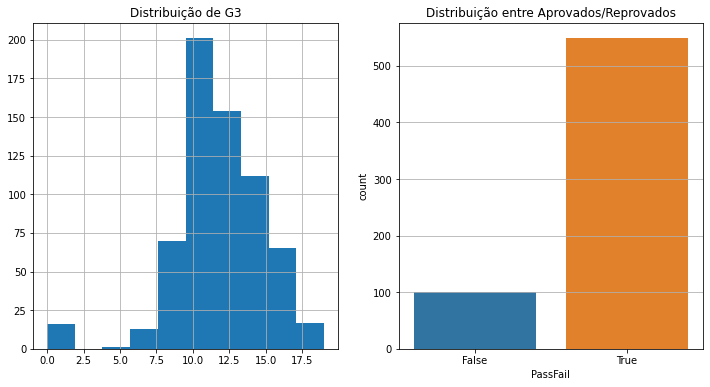

In [0]:
import numpy
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import theano
import theano.tensor as T
# from mlpstudent import test_mlp
# from cnnstudent import evaluate_lenet5


# ======================================================================================================================
# Read the data
# students_data = pd.read_csv('student-por.csv', sep=';', true_values=['yes'], false_values=['no'])
students_url = 'https://raw.githubusercontent.com/tomazellifelipe/PIBITI/master/student-por.csv'
students_data = pd.read_csv(students_url, sep=';', true_values=['yes'], false_values=['no'])


# Add boolean column PassFail
def passfail(row):
    if row['G3'] >= 10:
        return True
    else:
        return False


students_data['PassFail'] = students_data.apply(lambda row: passfail(row), axis=1)

# data visualisation
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
students_data.G3.hist(ax=axes[0])
axes[0].set_title("Distribuição de G3")
sns.countplot(x="PassFail", data=students_data, ax=axes[1])
axes[1].set_title("Distribuição entre Aprovados/Reprovados")
plt.grid(True, axis='y')
# plt.show()

# Separate target from predictors
Y = students_data.PassFail
X = students_data.drop(['absences', 'G1', 'G2', 'G3', 'PassFail'], axis=1)

# columns types
students_num_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]
students_cat_cols = [cname for cname in X.columns if X[cname].nunique() < 10 and
                     X[cname].dtype == "object"]
students_bool_cols = [cname for cname in X.columns if X[cname].dtype == "bool"]


def scale_numeric(data, numeric_columns, scaler):
    for col in numeric_columns:
        data[col] = scaler.fit_transform(data[col].values.reshape(-1, 1))
    return data


# We can now define the scaler we want to use and apply it to our dataset
scaler = StandardScaler()
X = scale_numeric(X, [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']], scaler)

# Keep selected columns only
my_cols = students_cat_cols + students_num_cols + students_bool_cols
X = X[my_cols].copy()

# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='constant')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, students_num_cols),
        ('cat', categorical_transformer, students_cat_cols),
        ('bool', 'passthrough', students_bool_cols)])

X = pd.DataFrame(preprocessor.fit_transform(X))
Y = pd.DataFrame(Y)

# Divide data into training, validation and test subsets
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, train_size=0.8, test_size=0.2, shuffle=True)
X_valid, X_test, Y_valid, Y_test = train_test_split(X_valid, Y_valid, train_size=0.8, test_size=0.2,
                                                    shuffle=True)
train_set = (X_train, Y_train)
print(f'X_train shape = {X_train.shape}')
print(f'Y_trains shape = {Y_train.shape}')
valid_set = (X_valid, Y_valid)
print(f'X_valid shape = {X_valid.shape}')
print(f'Y_valid shape = {Y_valid.shape}')
test_set = (X_test, Y_test)
print(f'X_test shape = {X_test.shape}')
print(f'Y_test shape = {Y_test.shape}')


def shared_dataset(data_xy, borrow=True):
    """ Function that loads the dataset into shared variables

    The reason we store our dataset in shared variables is to allow
    Theano to copy it into the GPU memory (when code is run on GPU).
    Since copying data into the GPU is slow, copying a minibatch everytime
    is needed (the default behaviour if the data is not in a shared
    variable) would lead to a large decrease in performance.
    """
    data_x, data_y = data_xy
    shared_x = theano.shared(numpy.asarray(data_x,
                                           dtype=theano.config.floatX),
                             borrow=borrow)
    shared_y = theano.shared(numpy.asarray(data_y,
                                           dtype=theano.config.floatX),
                             borrow=borrow).flatten()
    # When storing data on the GPU it has to be stored as floats
    # therefore we will store the labels as ``floatX`` as well
    # (``shared_y`` does exactly that). But during our computations
    # we need them as ints (we use labels as index, and if they are
    # floats it doesn't make sense) therefore instead of returning
    # ``shared_y`` we will have to cast it to int. This little hack
    # lets ous get around this issue
    return shared_x, T.cast(shared_y, 'int32')


te_set_x, te_set_y = shared_dataset(test_set)
val_set_x, val_set_y = shared_dataset(valid_set)
tr_set_x, tr_set_y = shared_dataset(train_set)
dataset = [(tr_set_x, tr_set_y), (val_set_x, val_set_y), (te_set_x, te_set_y)]

# MLP ==================================================================================================================
#if __name__ == '__main__':
#    test_mlp(dataset)

# CNN ==================================================================================================================
if __name__ == '__main__':
    evaluate_lenet5(dataset)


def experiment(state, channel):
    evaluate_lenet5(state.learning_rate, dataset=state.dataset)